In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import sbibm

import os
import pickle
import io

/home/srayan/miniconda3/envs/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# device = "cpu"

In [4]:
task_name = "two_moons"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

# used for setting up dimensions
sample_c = prior.sample((1,))
sample_x = simulator(sample_c)
n = sample_c.shape[-1] # number of items (c in R^n)
d = sample_x.shape[-1] # dim of context to utility (x in R^d)
print(n, d)

2 2


In [5]:
N = 2_000
N_train = 1000
N_test  = 100

c_dataset = prior.sample((N,)).numpy()
x_dataset = simulator(c_dataset).numpy()

to_tensor = lambda r : torch.tensor(r).to(torch.float32).to(device)
x_train, x_cal = to_tensor(x_dataset[:N_train]), to_tensor(x_dataset[N_train:])
c_train, c_cal = to_tensor(c_dataset[:N_train]), to_tensor(c_dataset[N_train:])

c_test = prior.sample((N_test,)).numpy()
x_test = simulator(c_test).numpy()
c_test, x_test = to_tensor(c_test), to_tensor(x_test)

In [6]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)



In [7]:
print(os.getcwd())
cached_fn = os.path.join("../sbi/trained", f"{task_name}.nf")
with open(cached_fn, "rb") as f:
    encoder = CPU_Unpickler(f).load()
encoder.to(device)

/home/srayan/csi/conformal-po


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [8]:
# Gets the conformal quantile for a given alpha and k
def conformal_quantile(alpha, k, x_cal, c_cal, encoder):
    n_c = c_cal.shape[0]
    c_cal_hat = encoder.sample(k, x_cal).detach().cpu().numpy()
    print(c_cal_hat.shape)
    c_true = c_cal.detach().cpu().numpy().reshape(n_c, 1, -1)
    c_true = np.repeat(c_true, k, axis=1)
    scores_i = np.linalg.norm(c_cal_hat - c_true, axis=-1)
    scores = np.min(scores_i, axis=1)
    return np.quantile(scores, (n_c + 1)*(1 - alpha)/n_c)

In [9]:
volume_d_dict = {
    2: lambda r : np.pi * r**2,
    3: lambda r : 4/3 * np.pi * r**3,
    4: lambda r : np.pi**2/2 * r**4,
    5: lambda r : 8/15 * np.pi**2 * r**5,
    6: lambda r : np.pi**3/6 * r**6,
    7: lambda r : 16/105 * np.pi**3 * r**7,
    8: lambda r : np.pi**4/24 * r**8,
    9: lambda r : 32/945 * np.pi**4 * r**9,
    10: lambda r : np.pi**5/120 * r**10
}
def volume_d_ball(d, r):
    return volume_d_dict[d](r)

In [10]:
# Picks radius randomly from the interval [0, 1] and picks a direction uniformly at random
def mullers_sample_from_ball(center, r, N, d):
    u = np.random.normal(0, 1, (N, d))
    norm = np.linalg.norm(u, axis=1)
    radius = np.random.uniform(0, 1, N)**(1/d)
    u = r * radius.reshape(-1, 1) * u / norm.reshape(-1, 1)
    u = u + center 
    return u


In [90]:
def sample_from_k_balls_assign_voronoi(r, N, d, k, encoder, x_test):

    # Getting the centers of the k balls
    centers = encoder.sample(k, x_test).detach().cpu().numpy().reshape(k, -1)
    # center_tiled = np.repeat(centers.reshape(k, 1, -1), N, axis=1)

    # Samples from the k balls
    samples = np.zeros((k, N, d))
    print(samples.shape)

    # Giving the voronoi assignments
    voronoi_assignments = np.zeros((k, N))

    # fraction of samples in each ball in the associated voronoi cell
    fractions = np.zeros(k)

    # vectorized 
    samples = np.apply_along_axis(mullers_sample_from_ball, axis=1, arr=centers, r=r, N=N, d=d)
    # dist = np.apply_over_axes(np.linalg.norm, samples - center_tiled, axes=[-1])
    dist = np.linalg.norm(samples.reshape(k, N, 1, -1) - centers, axis=-1)
    voronoi_assignments = np.argmin(dist, axis=-1)
    fractions = np.sum(voronoi_assignments == np.arange(k).reshape(-1, 1), axis=1)/N
    # fractions = np.array([np.sum(voronoi_assignments[i] == i)/N for i in range(k)])

    # print(sums)
    # np.random.seed(0)
    # for i in range(k):
    #     # Sampling from the ith ball
    #     samples[i] = mullers_sample_from_ball(centers[i], r, N, d)

    #     # Giving voronoi assignments
    #     dist = np.linalg.norm(samples[i] - center_tiled, axis=-1)
    #     voronoi_assignments[i] = np.argmin(dist, axis=0)
    #     fractions[i] = np.sum(voronoi_assignments[i] == i)/N
    # # Assigning each sample to the closest center

    # center_tiled = np.tile(np.repeat(centers.reshape(k, 1, -1), N, axis=1),(k, 1, 1, 1))
    # samples_tiled = np.tile(samples.reshape(k, N, -1), (k, 1, 1, 1))
    volume = sum(fractions)*volume_d_ball(d, r)
    

    return centers, samples, voronoi_assignments, fractions, volume


In [15]:
def multiple_experiment_run(r, N, d, range_k, encoder, x_test):
    size_of_x = x_test.shape[0]
    print(len(range_k))
    volumes = np.zeros((size_of_x, len(range_k)))
    for j in range(size_of_x):
        z = 0
        print("Sample: {}", j)
        for i in range_k:
            centers, _, _, fractions, volume = sample_from_k_balls_assign_voronoi(r[z], N, d, i, encoder, x_test[j].reshape(1, -1))
            volumes[j, z] = volume
            z += 1
    return volumes

        


In [13]:
range_k = range(1, 50)
q_hat = conformal_quantile(0.05, 10, x_cal, c_cal, encoder)
q_hats = [conformal_quantile(0.05, k, x_cal, c_cal, encoder) for k in range_k]
print(q_hat)

/home/srayan/miniconda3/envs/.conda/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  outputs, _ = torch.triangular_solve(


(1000, 10, 2)
(1000, 1, 2)
(1000, 2, 2)
(1000, 3, 2)
(1000, 4, 2)
(1000, 5, 2)
(1000, 6, 2)
(1000, 7, 2)
(1000, 8, 2)
(1000, 9, 2)
(1000, 10, 2)
(1000, 11, 2)
(1000, 12, 2)
(1000, 13, 2)
(1000, 14, 2)
(1000, 15, 2)
(1000, 16, 2)
(1000, 17, 2)
(1000, 18, 2)
(1000, 19, 2)
(1000, 20, 2)
(1000, 21, 2)
(1000, 22, 2)
(1000, 23, 2)
(1000, 24, 2)
(1000, 25, 2)
(1000, 26, 2)
(1000, 27, 2)
(1000, 28, 2)
(1000, 29, 2)
(1000, 30, 2)
(1000, 31, 2)
(1000, 32, 2)
(1000, 33, 2)
(1000, 34, 2)
(1000, 35, 2)
(1000, 36, 2)
(1000, 37, 2)
(1000, 38, 2)
(1000, 39, 2)
(1000, 40, 2)
(1000, 41, 2)
(1000, 42, 2)
(1000, 43, 2)
(1000, 44, 2)
(1000, 45, 2)
(1000, 46, 2)
(1000, 47, 2)
(1000, 48, 2)
(1000, 49, 2)
0.09897688323482871


In [91]:
# Test run with k = 1, .., 50 and 0th sample
centers, samples, voronoi_cells, fractions, volume = sample_from_k_balls_assign_voronoi(q_hat, 10000, d, 10, encoder, x_test[0].reshape(1, -1))
# somethingsomething= [sample_from_k_balls_assign_voronoi(r = q_hats[k -1], N = 100, d = d, k = k, encoder = encoder, x_test = x_test[0].reshape(1, -1)) for k in range(1, 50)]
# print(fractions)
print(volume)
print(voronoi_cells[0])
print(fractions)

some_samples = samples.reshape(-1, d)

(10, 10000, 2)
0.14492593495521594
[4 0 2 ... 2 4 1]
[0.3141 0.2193 0.5438 0.171  0.6302 0.2157 0.8238 0.602  0.3898 0.7993]


In [22]:
def get_grid(size = 200, dim = 2, prior= None):
    mins = prior.support.base_constraint.lower_bound.cpu().numpy()
    maxs = prior.support.base_constraint.upper_bound.cpu().numpy()
    ranges = [np.arange(mins[i], maxs[i], (maxs[i] - mins[i]) / size) for i in range(d)]
    return np.array(np.meshgrid(*ranges)).T.astype(np.float32).reshape(-1, dim)

In [40]:
def compute_actual_volume(radius, centers, prior):
    grid = get_grid(prior=prior)
    n = grid.shape[0]
    k = centers.shape[0]
    c_true = np.repeat(grid.reshape(-1, 1, 2), k, axis=1)
    scores_i = np.linalg.norm(centers- c_true, axis=-1)
    scores = np.min(scores_i, axis=1)
    num = scores < radius
    length_of_rect = np.max(grid[:, 0]) - np.min(grid[:, 0])
    width_of_rect = np.max(grid[:, 1]) - np.min(grid[:, 1])
    return np.sum(num) * length_of_rect * width_of_rect / n, grid[num]

In [41]:
volume_true, gridd =  compute_actual_volume(q_hat, centers, prior)
print(volume_true)
print(gridd)

0.048412222964015005
[[-1.   -0.38]
 [-1.   -0.37]
 [-1.   -0.36]
 [-1.   -0.35]
 [-1.   -0.34]
 [-1.   -0.33]
 [-1.   -0.32]
 [-1.   -0.31]
 [-1.   -0.3 ]
 [-1.   -0.29]
 [-1.   -0.28]
 [-1.   -0.27]
 [-1.   -0.26]
 [-1.   -0.25]
 [-1.   -0.24]
 [-1.   -0.23]
 [-1.   -0.22]
 [-1.   -0.21]
 [-1.   -0.2 ]
 [-1.   -0.19]
 [-1.   -0.18]
 [-1.   -0.17]
 [-1.   -0.16]
 [-1.   -0.15]
 [-1.   -0.14]
 [-1.   -0.13]
 [-1.   -0.12]
 [-1.   -0.11]
 [-1.   -0.1 ]
 [-0.99 -0.37]
 [-0.99 -0.36]
 [-0.99 -0.35]
 [-0.99 -0.34]
 [-0.99 -0.33]
 [-0.99 -0.32]
 [-0.99 -0.31]
 [-0.99 -0.3 ]
 [-0.99 -0.29]
 [-0.99 -0.28]
 [-0.99 -0.27]
 [-0.99 -0.26]
 [-0.99 -0.25]
 [-0.99 -0.24]
 [-0.99 -0.23]
 [-0.99 -0.22]
 [-0.99 -0.21]
 [-0.99 -0.2 ]
 [-0.99 -0.19]
 [-0.99 -0.18]
 [-0.99 -0.17]
 [-0.99 -0.16]
 [-0.99 -0.15]
 [-0.99 -0.14]
 [-0.99 -0.13]
 [-0.99 -0.12]
 [-0.99 -0.11]
 [-0.99 -0.1 ]
 [-0.98 -0.37]
 [-0.98 -0.36]
 [-0.98 -0.35]
 [-0.98 -0.34]
 [-0.98 -0.33]
 [-0.98 -0.32]
 [-0.98 -0.31]
 [-0.98 -0.3 ]
 [-0

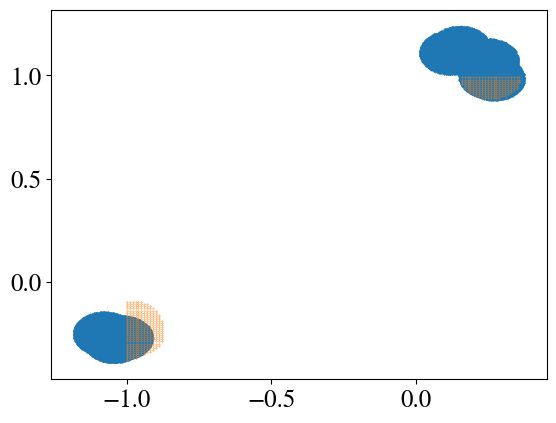

In [43]:
plt.scatter(some_samples[:, 0], some_samples[:, 1], s=0.1)
plt.scatter(gridd[:, 0], gridd[:, 1], s=0.1)

[11.192535269871541, 7.1650659399887795, 3.851547861223167, 0.7246707672763582, 0.19993706992017987, 0.1438875062654188, 0.13919386236580072, 0.13477863462612105, 0.11703576680323174, 0.12461179468154729, 0.08739106611610964, 0.08754085071930286, 0.10209934378089405, 0.07320116195488437, 0.08472226255429702, 0.07298214645531907, 0.06221772736922717, 0.06914155392999471, 0.06813227350415307, 0.05554922464518274, 0.058802855364628884, 0.061449055196218655, 0.05890199191641496, 0.06193596729871837, 0.055233265848805904, 0.04538271868904415, 0.053669416526025214, 0.06064452190805227, 0.04978225696702301, 0.052517196243743736, 0.04837742611351544, 0.05279536945455882, 0.05496303911921852, 0.047930959797943505, 0.049624973138238, 0.042123319381852875, 0.053651638591587926, 0.047168555265165966, 0.04474173584976823, 0.04603942667056387, 0.042556184538183946, 0.04336754361435403, 0.042505707768759456, 0.04418003522022423, 0.04656917609360246, 0.04189524368440538, 0.04435619027134177, 0.0400053

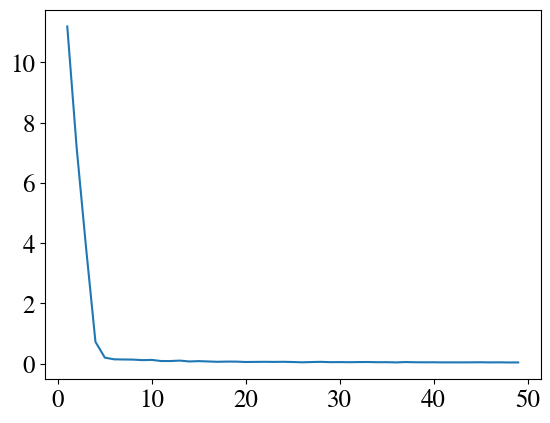

In [40]:
volumes = [somethingsomething[i - 1][3] for i in range(1, 50)]
print(volumes)
some = np.arange(1, 50)
plt.plot(some, volumes)

In [41]:
volumes = multiple_experiment_run(q_hats, 100, d, range_k, encoder, x_test)

49
Sample: {} 0
Sample: {} 1
Sample: {} 2
Sample: {} 3
Sample: {} 4
Sample: {} 5
Sample: {} 6
Sample: {} 7
Sample: {} 8
Sample: {} 9
Sample: {} 10
Sample: {} 11
Sample: {} 12
Sample: {} 13
Sample: {} 14
Sample: {} 15
Sample: {} 16
Sample: {} 17
Sample: {} 18
Sample: {} 19
Sample: {} 20
Sample: {} 21
Sample: {} 22
Sample: {} 23
Sample: {} 24
Sample: {} 25
Sample: {} 26
Sample: {} 27
Sample: {} 28
Sample: {} 29
Sample: {} 30
Sample: {} 31
Sample: {} 32
Sample: {} 33
Sample: {} 34
Sample: {} 35
Sample: {} 36
Sample: {} 37
Sample: {} 38
Sample: {} 39
Sample: {} 40
Sample: {} 41
Sample: {} 42
Sample: {} 43
Sample: {} 44
Sample: {} 45
Sample: {} 46
Sample: {} 47
Sample: {} 48
Sample: {} 49
Sample: {} 50
Sample: {} 51
Sample: {} 52
Sample: {} 53
Sample: {} 54
Sample: {} 55
Sample: {} 56
Sample: {} 57
Sample: {} 58
Sample: {} 59
Sample: {} 60
Sample: {} 61
Sample: {} 62
Sample: {} 63
Sample: {} 64
Sample: {} 65
Sample: {} 66
Sample: {} 67
Sample: {} 68
Sample: {} 69
Sample: {} 70
Sample: {} 71

Text(0.5, 1.0, 'Two Moons')

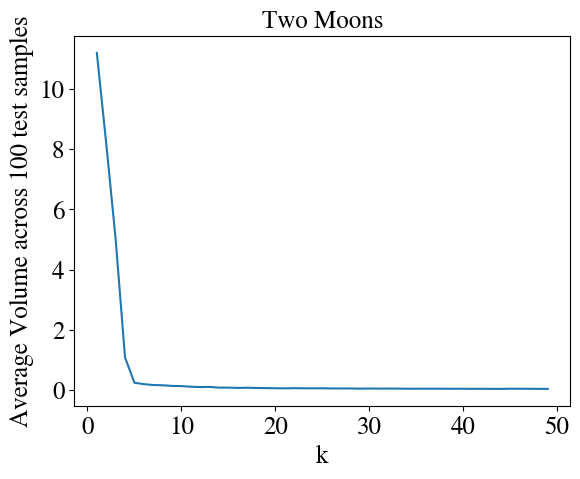

In [43]:
avg_volume = np.mean(volumes, axis=0)
some = np.arange(1, 50)
plt.plot(some, avg_volume)
plt.xlabel("k")
plt.ylabel("Average Volume across 100 test samples")
plt.title("Two Moons")